In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import pybedtools as bt

from collections import Counter, deque
import pickle
import re
import os

from mycolorpy import colorlist as mcp
import matplotlib.patches as mpatches
import matplotlib.collections as mcol
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from matplotlib_venn import venn3, venn2


from matplotlib import gridspec
from scipy.stats import shapiro, mannwhitneyu, iqr,spearmanr, ttest_rel, ttest_ind, fisher_exact, chisquare, pearsonr
from statsmodels.stats.multitest import multipletests 
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix,roc_auc_score,RocCurveDisplay, roc_curve

import sys
sys.path.append("/home/ualtintas/bluegill/")
import bluegill.run as bgrun
import bluegill.plt as bgplt

from adjustText import adjust_text

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
import statsmodels.api as sm
from glmnet import ElasticNet,LogitNet

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-7:-2]
color3=mcp.gen_color(cmap="Blues",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
color5=mcp.gen_color(cmap="Purples",n=10)[-7:-2]

def get_aster(p):
    if p <= 0.0001:
        aster= "****"
    elif p <= 0.001:
        aster= "***"
    elif p <= 0.01:
        aster= "**"
    elif p <= 0.05:
        aster= "*"
    else:
        aster= 'ns'
    return aster

MAPty = pickle.load(open('zenodo/MAPty.p', 'rb'))
MAPcl = pickle.load(open('zenodo/MAPcl.p', 'rb'))
MAPgn = pickle.load(open('zenodo/MAPgn.p', 'rb'))
BEDPRO = pickle.load(open('zenodo/BEDPRO.p', 'rb'))

H = pickle.load(open('zenodo/G_ALL.p', 'rb'))

def quantileNormalize(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

    
sns.set(font_scale=2, style='ticks')

    

/tmp/ipykernel_199034/1384484828.py:129: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = np.array(nx.adjacency_matrix(H).todense())


In [2]:

rna = np.log(BEDPRO[['Gene', 'Vh', '30m', '4h', '16h', '72h']].set_index('Gene')+1).to_dict('index')

P = [k for k, v in MAPty.items() if v == 'Promoter']


CI = []
EX = []
for p in P:
    if p not in H:
        continue
    neig = list(H.neighbors(p))
    if len(neig) < 1:
        continue


    for e in neig: 
        
        w = H.get_edge_data(p, e)
        CI.append([p,e] + list(w.values()) )
    
    EX.append([p,e] + list(rna[MAPgn[p]].values()) )

        

CI = pd.DataFrame(CI, columns=['Promoter', 'Enhancer'] + list(w.keys()))

EX = pd.DataFrame(EX, columns=['Promoter', 'Enhancer', 'Exp_Vh', 'Exp_30m', 'Exp_4h' ,'Exp_16h', 'Exp_72h'])


Vh H3K27ac 0.5965434892266884 4.3216798367813505e-50 avg
Vh H3K27ac 0.8674061569416279 6.919350196961828e-155 max
Vh H3K27ac 0.911570982526025 1.1036265988568872e-196 sum
Vh H3K4me3 0.65103087016933 2.4682217714707328e-62 avg
Vh H3K4me3 0.8735259629197547 1.0557570051675631e-159 max
Vh H3K4me3 0.9051372365612497 2.3075931614589076e-189 sum
30m H3K27ac 0.6069827021181072 2.967812938771548e-52 avg
30m H3K27ac 0.8606988424665267 7.084727668568252e-150 max
30m H3K27ac 0.9037712471465563 7.079505985943197e-188 sum
30m H3K4me3 0.6547267124527284 2.947173731695258e-63 avg
30m H3K4me3 0.8720615519477684 1.5799206605686335e-158 max
30m H3K4me3 0.9019785372290294 5.85960102935673e-186 sum
4h H3K27ac 0.5413634112836611 7.1971026687298574e-40 avg
4h H3K27ac 0.8604776727476503 1.0257683373223457e-149 max
4h H3K27ac 0.9081227362985875 1.079943424155747e-192 sum
4h H3K4me3 0.670152642654191 2.969757201781336e-67 avg
4h H3K4me3 0.8707503280805652 1.7320198216558844e-157 max
4h H3K4me3 0.90438775735774

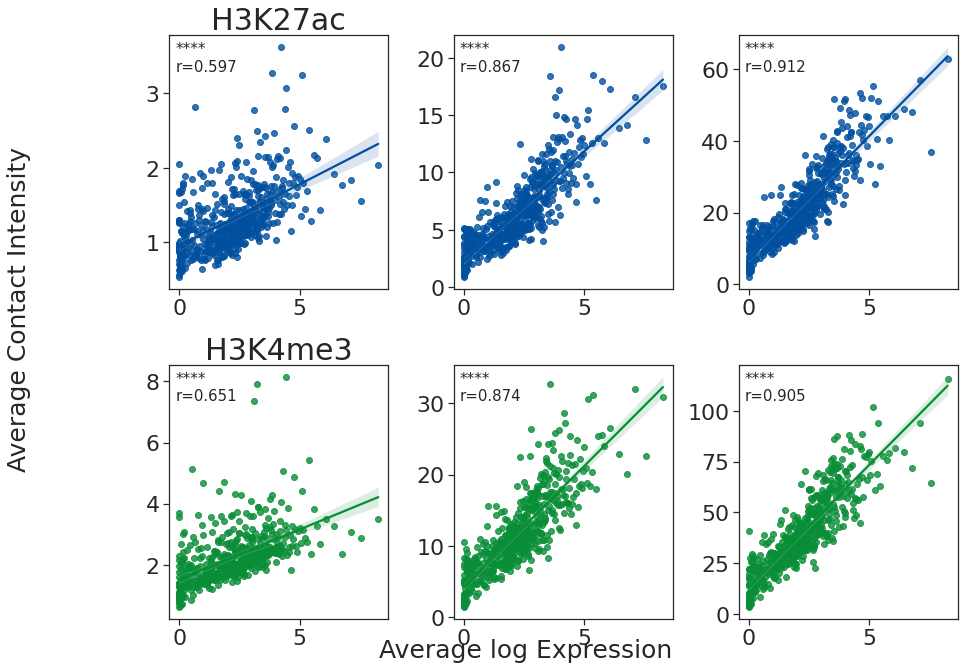

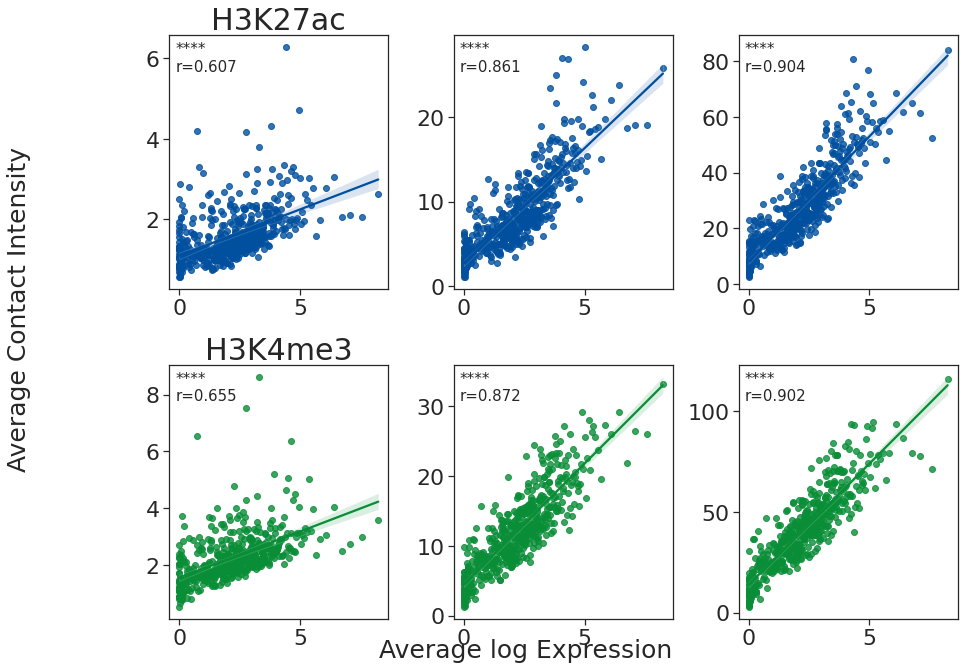

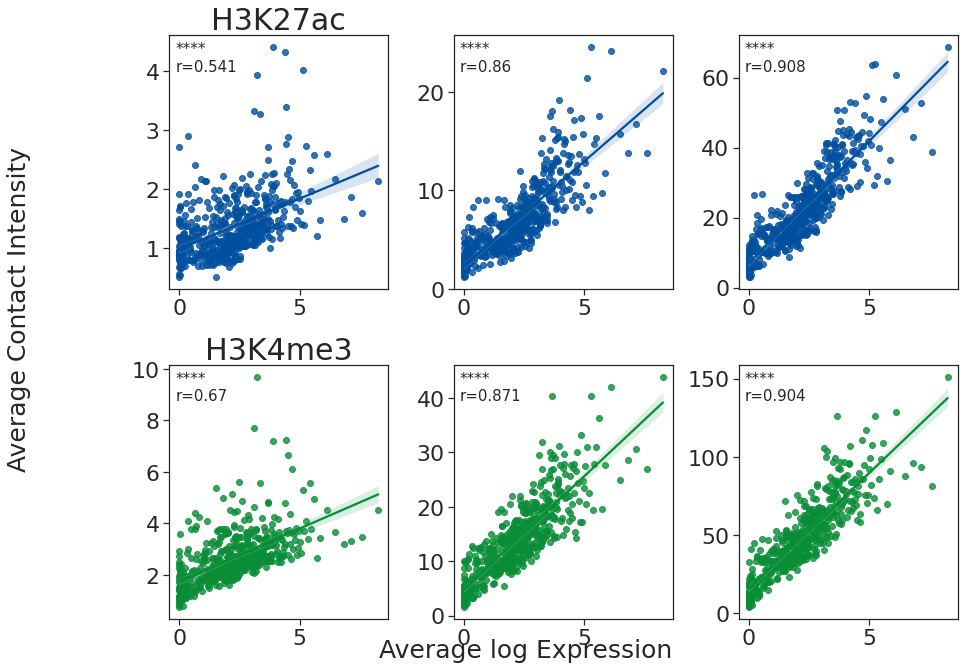

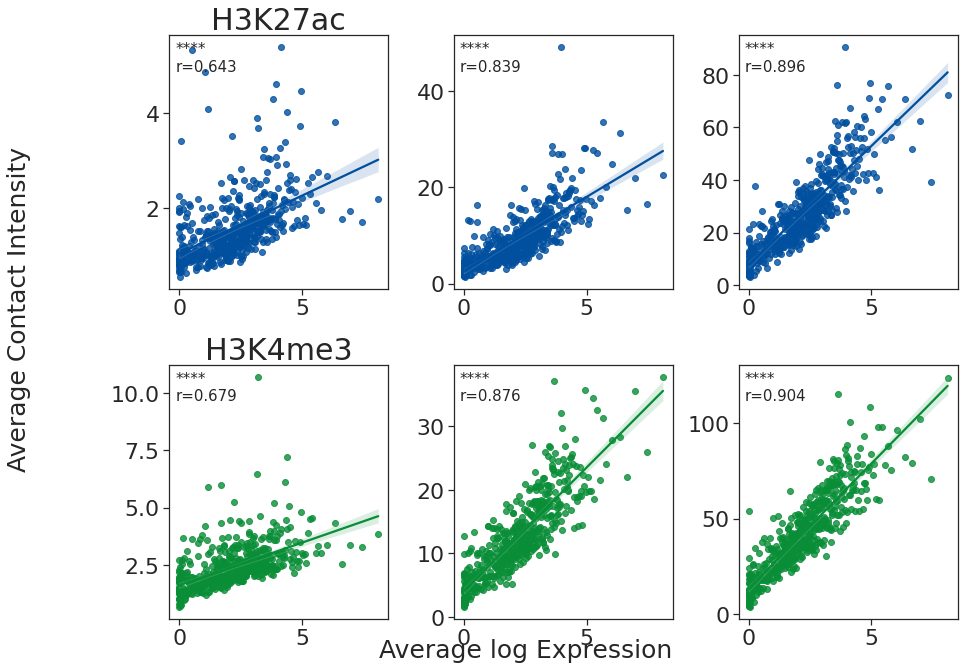

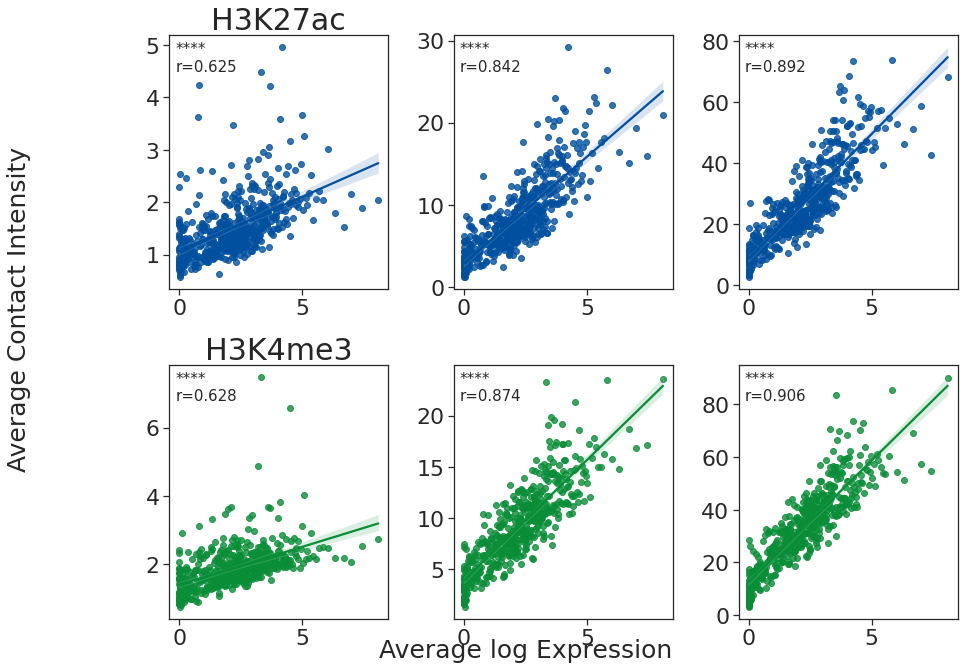

In [5]:
for t in ['Vh', '30m', '4h', '16h', '72h']:

	binsize = 25
	fig = plt.figure(figsize=[15,10])
	gs = gridspec.GridSpec(nrows=2, ncols=3, wspace=0.3, hspace=0.3, bottom=0.07, left=0.17)

	palette = ['#01509f', '#098e37']

	for i, signal in enumerate(['H3K27ac', 'H3K4me3']):
		
		fig.add_subplot(gs[i, 0])
		plt.title(signal, fontsize=30)
		ci = CI.groupby('Promoter').mean()[f'{signal}.{t}']
		ex = EX.groupby('Promoter').mean()[f'Exp_{t}']

		tmp = pd.DataFrame({'EX': ex, 'CI': ci}).sort_values('EX')
		tmp['Bin'] = [item for item in range(1+(tmp.shape[0] // binsize)) for i in range(binsize)][-tmp.shape[0] % binsize: ]
		tmp = tmp.groupby('Bin').mean()
		
		ax = sns.regplot(data=tmp, x="EX", y="CI", color=palette[i],order=1)
		r, p = spearmanr(tmp["EX"],tmp["CI"])
		print(t, signal, r,p, 'avg')

		anchored_text = AnchoredText(f'{get_aster(p)}\nr={np.round(r, 3)}', loc=2,borderpad=0.,frameon=False,  prop={'fontsize': 15})
		ax.add_artist(anchored_text)
		
		plt.ylabel('')
		plt.xlabel('')
		#############

		fig.add_subplot(gs[i,1])
		ci = CI.groupby('Promoter').max()[f'{signal}.{t}']
		ex = EX.groupby('Promoter').max()[f'Exp_{t}']

		tmp = pd.DataFrame({'EX': ex, 'CI': ci}).sort_values('EX')
		tmp['Bin'] = [item for item in range(1+(tmp.shape[0] // binsize)) for i in range(binsize)][-tmp.shape[0] % binsize: ]
		tmp = tmp.groupby('Bin').mean()

		ax = sns.regplot(data=tmp, x="EX", y="CI", color=palette[i],order=1)

		r, p = spearmanr(tmp["EX"],tmp["CI"])
		print(t, signal, r,p, 'max')

		anchored_text = AnchoredText(f'{get_aster(p)}\nr={np.round(r, 3)}', loc=2,borderpad=0.,frameon=False,  prop={'fontsize': 15})
		ax.add_artist(anchored_text)

		plt.ylabel('')
		plt.xlabel('')
		#############


		fig.add_subplot(gs[i, 2])
		ci = CI.groupby('Promoter').sum()[f'{signal}.{t}']
		ex = EX.groupby('Promoter').sum()[f'Exp_{t}']

		tmp = pd.DataFrame({'EX': ex, 'CI': ci}).sort_values('EX')
		tmp['Bin'] = [item for item in range(1+(tmp.shape[0] // binsize)) for i in range(binsize)][-tmp.shape[0] % binsize: ]
		tmp = tmp.groupby('Bin').mean()

		ax = sns.regplot(data=tmp, x="EX", y="CI", color=palette[i],order=1)

		r, p = spearmanr(tmp["EX"],tmp["CI"])
		print(t, signal, r,p, 'sum')

		anchored_text = AnchoredText(f'{get_aster(p)}\nr={np.round(r, 3)}', loc=2,borderpad=0.,frameon=False,  prop={'fontsize': 15})
		ax.add_artist(anchored_text)

		
		plt.ylabel('')
		plt.xlabel('')
		#############


	fig.supxlabel('Average log Expression', fontsize=25)
	fig.supylabel('Average Contact Intensity', fontsize=25)


	#fig.savefig(f'../plots/ExpCi25_{t}.pdf', bbox_inches ="tight",  pad_inches = 1 )